In [3]:
import os 
import warnings 
warnings.filterwarnings('ignore')
from glob import glob 
from tqdm import tqdm 
import pickle 
import time 

import pandas as pd 
import numpy as np 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score,roc_curve,auc

import torch 
import torch.nn as nn  
from torch import Tensor
from torch.utils.data import Dataset,DataLoader 
from torch import optim 

from src.model import Discriminator,Generator,weights_init
from src.Dataset import SwatDataset
from src.Options import OPT

In [4]:
with open('./Data/pre_data.pickle','rb') as f:
    data = pickle.load(f)
opt = OPT()

train_set = SwatDataset(data,'train')
test_set = SwatDataset(data,'test')
train_loader = DataLoader(train_set,batch_size=opt.batchsize,shuffle=True)
test_loader = DataLoader(test_set,batch_size=opt.batchsize,shuffle=True)

In [7]:
def update_netd(batch_x):
    D.zero_grad()
    # Train with real 
    out_d_real, feat_real = D(batch_x)

    # Train with fake 
    fake, latent_i = G(batch_x)
    out_d_fake, feat_fake = D(fake)

    err_d_real =  bce_criterion(
                                out_d_real.type(torch.float64), 
                                torch.full((opt.batchsize,),  real_label).type(torch.float64).to(device)
                                )
    err_d_fake =  bce_criterion(
                                out_d_fake.type(torch.float64), 
                                torch.full((opt.batchsize,),  fake_label).type(torch.float64).to(device)
                                )

    err_d = err_d_real + err_d_fake
    err_d.backward()
    optimizerD.step()
    return err_d_real,err_d_fake

def update_netg(batch_x):
    G.zero_grad()
    fake,latent_i = G(batch_x)
    out_g,feat_fake = D(fake)
    _,feat_real = D(batch_x)

    err_g_adv = mse_criterion(feat_fake,feat_real)
    err_g_rec = mse_criterion(fake,batch_x)

    err_g = err_g_rec + err_g_adv * opt.w_adv
    err_g.backward()
    optimizerG.step()
    return err_g_rec,err_g_adv
    
def reinitialize_netd():
        """ Initialize the weights of netD
        """
        D.apply(weights_init)
        print('Reloading d net')       
        
def optimize(batch_x):
    err_d_real,err_d_fake = update_netd(batch_x)
    err_g_rec,err_g_adv = update_netg(batch_x)
    
    err_d = err_d_real.item() + err_d_fake.item() 
    err_g = err_g_rec.item() + err_g_adv.item()
    
    errors = {'err_d':err_d,
                    'err_g': err_g,
                    'err_d_real': err_d_real.item(),
                    'err_d_fake': err_d_fake.item(),
                    'err_g_adv': err_g_adv.item(),
                    'err_g_rec': err_g_rec.item(),
                  }
    
    if err_d < 5e-6:
        reinitialize_netd()
    return  errors           

def train_epoch(dataloader):
    global total_steps
    G.train()
    D.train()
    epoch_iter = 0 
    for batch_x,batch_y in dataloader:
        total_steps += opt.batchsize 
        epoch_iter +=1 
        
        batch_x,batch_y = batch_x.type(torch.float32).to(device),batch_y.type(torch.float32).to(device)
        
        errors = optimize(batch_x)
        
        if (epoch_iter % 1000) == 0:
            print(f"\n Epoch : {cur_epoch} | [{epoch_iter}/{dataloader.__len__()}]" )
            print(f"\n D_loss(R/F) : {errors['err_d_real']:.4f}/{errors['err_d_fake']:.4f}, G_loss : {errors['err_g']:.4f}")

    
##predict 
def predict(dataloader,scale=True):
    G.eval()
    D.eval()
    with torch.no_grad():

        an_scores = torch.zeros(size=(len(dataloader.dataset),), dtype=torch.float32, device= device)
        gt_labels = torch.zeros(size=(len(dataloader.dataset),), dtype=torch.long,    device= device)
        dis_feat = torch.zeros(size=(len(dataloader.dataset),  opt.ndf*16*10), dtype=torch.float32,device= device)


        for i, (batch_x,batch_y) in enumerate(dataloader):
            batch_x,batch_y = batch_x.type(torch.float32).to(device),batch_y.type(torch.float32).to(device)
            fake, latent_i =  G(batch_x)
            # error = torch.mean(torch.pow((d_feat.view( input.shape[0],-1)-d_gen_feat.view( input.shape[0],-1)), 2), dim=1)
            #
            error = torch.mean(
                torch.pow(( batch_x.view( batch_x.shape[0], -1) -  fake.view( fake.shape[0], -1)), 2),
                dim=1) # reconstruction loss 


            gt_labels[i* opt.batchsize : i* opt.batchsize+error.size(0)] =  torch.max(batch_y,dim=1).values.reshape(error.size(0)) #y 
            an_scores[i* opt.batchsize : i* opt.batchsize+error.size(0)] = error.reshape(error.size(0)) #y_pred
            
        # Scale error vector between [0, 1]
        if scale:
             an_scores = (an_scores - torch.min(an_scores)) / (torch.max(an_scores) - torch.min(an_scores))

        y_= gt_labels.detach().cpu().numpy()
        y_pred = an_scores.detach().cpu().numpy()

        return y_,y_pred
def evaluate(train_loader,test_loader):
    test_y,test_y_pred = predict(test_loader)
    train_y,train_y_pred = predict(train_loader)
    #thres = np.percentile(np.concatenate([test_y_pred,train_y_pred]),10)
    thres = 0.02 
    
    y_pred_thres = pd.Series(test_y_pred).apply(lambda x : 1 if x > thres else 0).values
    #auc = accuracy_score(y,y_pred)
    precision, recall, f_score, support = precision_recall_fscore_support(test_y, y_pred_thres,
                                                                                average='binary')
    fpr,tpr,thr = roc_curve(test_y,test_y_pred)
    auroc = auc(fpr,tpr)
    
    return precision, recall, f_score, auroc     

def validate(dataloader,thres):
    y_,y_pred = predict(dataloader)
    precision, recall, f_score, auroc = evaluate(y_,y_pred,thres)
    return precision, recall, f_score, auroc 
        

In [8]:
#def model_load():
device = 'cuda:1'
D = torch.load('./save_models/D.pt').to(device)
G = torch.load('./save_models/G.pt').to(device)

In [9]:
test_y,test_y_pred = predict(test_loader)
train_y,train_y_pred = predict(train_loader)

In [75]:
precision, recall, f_score, auroc = evaluate(train_loader,test_loader)

In [77]:
print(precision, recall, f_score, auroc)

0.24492360310792222 0.9996661811119204 0.39344986771933804 0.677720344550622


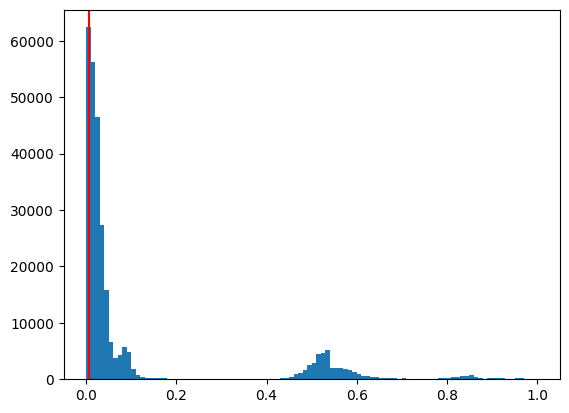

In [73]:
thres = np.percentile(np.concatenate([test_y_pred,train_y_pred]),10)
plt.hist(temp,bins=100)
plt.axvline(thres,color='r')

0.00918879546225071